In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pykitti
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement

In [3]:
np.set_printoptions(suppress=True, precision=6)
np.set_printoptions(edgeitems=30, linewidth=120)
basedir, date, drive = '../datasets/KITTI_SAMPLE_RAW/KITTI_SAMPLE/RAW', '2011_09_26', '0009'
dataset = pykitti.raw(basedir, date, drive, frames=range(0, 445, 1))

In [119]:
oxts_positions = np.array([oxts_data.T_w_imu[:3, -1] for oxts_data in dataset.oxts])
x, y, z = oxts_positions[:, 0], oxts_positions[:, 1], oxts_positions[:, 2]

Text(0.5, 1.0, 'X-Z)')

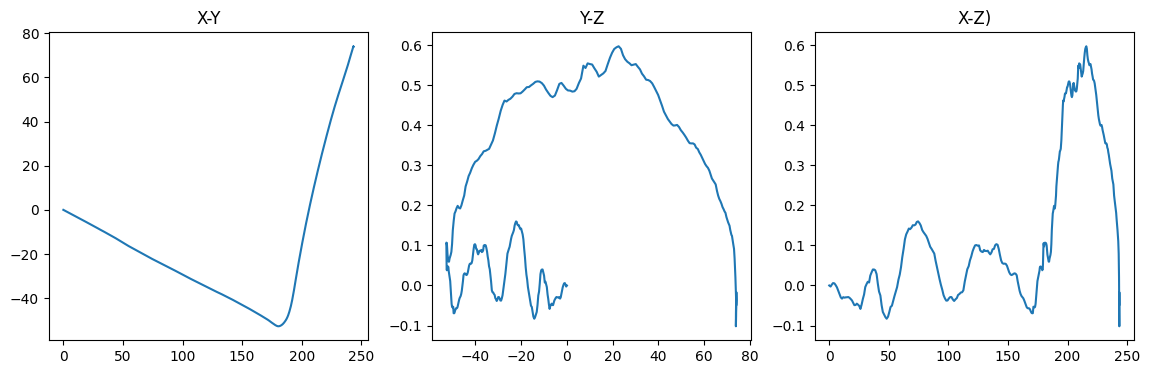

In [132]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(x, y)
plt.title('X-Y')
plt.subplot(1, 3, 2)
plt.plot(y, z)
plt.title('Y-Z')
plt.subplot(1, 3, 3)
plt.plot(x, z)
plt.title('X-Z)')


In [133]:
def transform_points(points, transformation):
    n_points = points.shape[0]
    points_homogeneous = np.hstack((points, np.ones((n_points, 1))))  
    transformed_points = (transformation @ points_homogeneous.T).T
    return transformed_points[:, :3]  

In [ ]:
fused_points = []
for i, scan in enumerate(dataset.velo):
    points = scan[:, :3] 
    transformation = dataset.oxts[i].T_w_imu 
    transformed_scan = transform_points(points, transformation)
    fused_points.append(transformed_scan)

In [ ]:
fused_points = np.vstack(fused_points)
images = [dataset.get_cam2(idx) for idx in range(50)]

In [ ]:
ply_element = PlyElement.describe(colored_points, 'vertex')
with open('fused_cloud.ply', 'wb') as f:
    PlyData([ply_element]).write(f)

print("Nuage de points fusionné exporté au format PLY.")

ValueError: only one-dimensional arrays are supported

In [92]:
n_images = 50
n_oxts = 445

In [111]:
points_clouds = [dataset.get_velo(idx) for idx in range(n_images)]
images = [dataset.get_cam2(idx) for idx in range(n_images)]
oxts = np.array([oxts_data.T_w_imu[:, -1] for oxts_data in dataset.oxts])

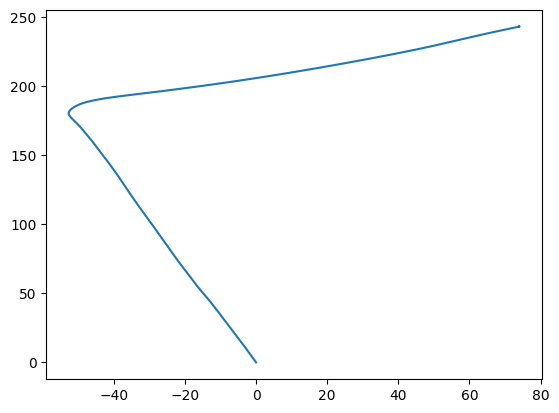

In [113]:
plt.plot(oxts[:, 1], oxts[:, 0])

In [97]:
print(dataset.poses)

AttributeError: 'raw' object has no attribute 'poses'

In [73]:
print(oxts[0])
print(oxts[2])


[[ 0.963843  0.265882 -0.017728  0.      ]
 [-0.266468  0.9613   -0.069986  0.      ]
 [-0.001566  0.072179  0.99739   0.      ]
 [ 0.        0.        0.        1.      ]]
[[ 0.963859  0.265923 -0.016142  2.163013]
 [-0.266401  0.96147  -0.067866 -0.612029]
 [-0.002527  0.069713  0.997564  0.002228]
 [ 0.        0.        0.        1.      ]]


In [74]:
oxts[2][0][-1]

2.1630128466058522

In [ ]:
print()

In [67]:
print(oxts[1][1][0])

-0.2663542648516522


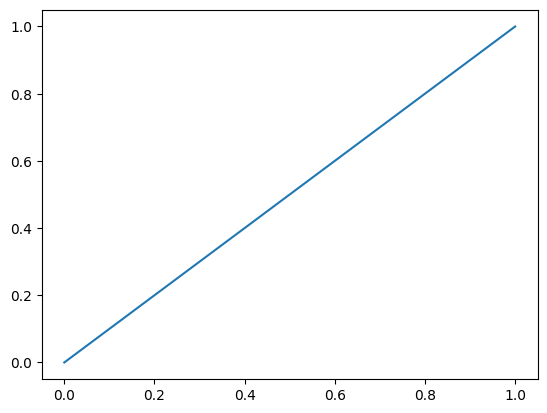

In [76]:
oxts[:][2][-1]plt.plot(oxts[:][1][-1], oxts[:][2][-1])

In [64]:
plt.plot(oxts[0,0,-1], oxts[0, 1, -1])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print()

In [13]:
print(dataset.oxts[1].T_w_imu)

[[ 0.963875  0.265633 -0.019583  1.130838]
 [-0.266354  0.961301 -0.070401 -0.32159 ]
 [ 0.000124  0.073074  0.997327 -0.002647]
 [ 0.        0.        0.        1.      ]]


In [115]:
!pip install plyfile

Text(0.5, 0, 'Z Label')

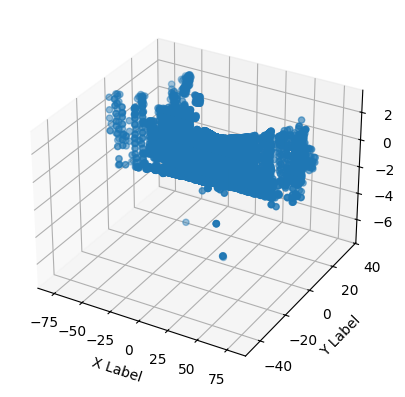

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points_cloud[:, 0], points_cloud[:, 1], points_cloud[:, 2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pykitti
from plyfile import PlyData, PlyElement



# Transformation LIDAR vers caméra et caméra vers global
T_cam2_velo = dataset.calib.T_cam2_velo
K_cam2 = dataset.calib.K_cam2

# Initialisation des listes pour stocker les points globaux et les couleurs
global_points = []
global_colors = []

# Boucle sur les frames du LIDAR
for i in range(50):  # Limitation à 50 frames pour des performances raisonnables
    # Transformation globale (repère LIDAR -> monde)
    T_w_velo = dataset.oxts[i].T_w_imu @ np.linalg.inv(dataset.calib.T_velo_imu)

    # Points LIDAR
    velo_points = dataset.get_velo(i)
    velo_points = velo_points[velo_points[:, 0] > 5]  # Filtrer pour X >= 5
    velo_points_hom = np.hstack((velo_points[:, :3], np.ones((velo_points.shape[0], 1))))  # Homogénéisation

    # Points dans le repère global
    points_global = (T_w_velo @ velo_points_hom.T).T[:, :3]

    # Points dans le repère caméra
    points_cam = (T_cam2_velo @ velo_points_hom.T).T[:, :3]

    # Projection des points sur l'image
    points_2d = (K_cam2 @ points_cam.T).T
    points_2d = points_2d[:, :2] / points_2d[:, 2:3]  # Normalisation homogène

    # Récupération de l'image
    img = np.array(dataset.get_cam2(i))
    height, width, _ = img.shape

    # Masque pour filtrer les points projetés valides
    mask = (
        (points_2d[:, 0] >= 0) & (points_2d[:, 1] >= 0) &
        (points_2d[:, 0] < width) & (points_2d[:, 1] < height)
    )
    points_2d = points_2d[mask]
    points_global = points_global[mask]

    # Couleurs correspondant aux points projetés
    colors = img[points_2d[:, 1].astype(int), points_2d[:, 0].astype(int)]

    # Stockage des points globaux et des couleurs
    global_points.append(points_global)
    global_colors.append(colors)

# Fusionner tous les points et les couleurs
global_points = np.vstack(global_points)
global_colors = np.vstack(global_colors)

# Sauvegarde au format PLY

# Combinaison des points 3D et des couleurs dans un format structuré
vertex = np.array(
    [(x, y, z, r, g, b) for (x, y, z), (r, g, b) in zip(global_points, global_colors)],
    dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
           ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
)

# Création de l'élément PLY
el = PlyElement.describe(vertex, 'vertex')

# Écriture dans un fichier PLY
output_filename = "nuage_de_points_fusionne2.ply"
ply_data = PlyData([el])
ply_data.write(output_filename)

print(f"Nuage de points fusionné exporté dans le fichier {output_filename}")

Nuage de points fusionné exporté dans le fichier nuage_de_points_fusionne2.ply
